# TP Geoloc - IoT

Sébastien Chapeland  
Adrien Ly  
Thomas Meimoun  
Margaux Rodrigues

## Les fonctions utilisées dans ce notebook :

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from math import sin, cos, sqrt, atan2, radians
from sklearn.linear_model import LinearRegression
from random import shuffle
from xgboost import XGBRegressor
import random
import warnings

warnings.filterwarnings('ignore')

In [2]:
def lodo(X_train, y_train, X_test, model):
    
    df_concat = pd.concat(axis=1, objs=[X_train,y_train], sort=False, copy=True)
    X_train_new, X_test_new = feat2(X_train, X_test)
    y_train_new = pd.concat(axis=1,objs=[X_train.messid,y_train],sort=False, copy=True)
    y_train_new = y_train_new.groupby('messid', sort=False).mean()

    list_did = df_concat.did.unique()
    df_score = pd.DataFrame()
    
    # Fit le model sur tous les devices sauf 1 :
    for i in range (len(list_did)):
        
        # split en train et test: 
        train_msg_list = df_concat[df_concat['did'] != list_did[i]]['messid'].unique()
        test_msg_list = df_concat[df_concat['did'] == list_did[i]]['messid'].unique()
        train_set = X_train_new.loc[train_msg_list]
        train_y = y_train_new.loc[train_msg_list]
        test_set = X_train_new.loc[test_msg_list]
        test_y = y_train_new.loc[test_msg_list]
        
        # Model
        md = model.fit(train_set.values, train_y.values)
        
        # Prediction
        prediction = md.predict(test_set.values)
        score_lodo = score(md,test_set.values,test_y.values)*-1
        
        # Output
        a= pd.DataFrame(np.repeat(a=list_did[i],axis=0,repeats=test_set.shape[0]))
        b= pd.DataFrame(test_set.index.values)
        c= pd.DataFrame(np.repeat(a=score_lodo, axis=0, repeats=test_set.shape[0]))
        d= pd.DataFrame(prediction)
        e= test_y.reset_index(drop=True)
        f= pd.concat(axis=1, objs=[a,b,c,d,e], sort= False)
        df_score = df_score.append(f)   
    df_score = pd.DataFrame(data=df_score.values,
                            columns=['did','messid','dist_error','lat_pred','lng_pred','lat_true','lng_true'],
                            copy=True)
        
    return df_score

def feat2(train,test):
    """
    Transformation des features de la matrice:
    
    1- Séparation en latitude et longitude des coordonnées des stations et OneHotencoding 
    2- Pondération par l'inverse de la distance calculée à partir des RSSI
    3- Pondération moyennées
    4- Groupby Messid
    """
    # Garde l'index de séparation entre le test et le train
    split = train.groupby('messid').max().shape[0]
    
    # Conversion du RSSI en distance et concaténation du test et du train
    train['rssi_conversion'] = [rssi_conversion(train.rssi.values[i]) for i in range(train.shape[0])]
    test['rssi_conversion'] = [rssi_conversion(test.rssi.values[i]) for i in range(test.shape[0])]
    concat = pd.concat([train,test], sort=False, copy=True)

    # Transformation des Latitudes des bases HotEncoded et pondérées par l'inverse de la distance RSSI
    oh_lat = pd.get_dummies(concat.bs_lat)
    weights = oh_lat.multiply((concat.rssi_conversion.values+concat.nseq.values)**-1, axis='index')
    oh_lat_weighted = weights#.multiply(oh_lat.columns.values)
    weights['messid'] = concat.messid
    oh_lat_weighted['messid'] = concat.messid
    numerateur_lat = oh_lat_weighted.groupby('messid',sort=False).sum()
    denom_lat = weights.groupby('messid',sort=False).sum().sum(axis=1)
    matrix_weighted_lat = numerateur_lat.multiply(denom_lat**-1, axis='index')

    # Transformation des Latitudes des bases hotencodées et pondérées par l'inverse de la distance RSSI
    oh_lng = pd.get_dummies(concat.bs_lng)
    weights = oh_lng.multiply((concat.rssi_conversion.values+concat.nseq.values)**-1, axis='index')
    oh_lng_weighted = weights#.multiply(oh_lng.columns.values)
    weights['messid'] = concat.messid
    oh_lng_weighted['messid'] = concat.messid
    numerateur_lng = oh_lng_weighted.groupby('messid',sort=False).sum()
    denom_lng = weights.groupby('messid',sort=False).sum().sum(axis=1)
    matrix_weighted_lng = numerateur_lng.multiply(denom_lng**-1, axis='index')

    # Concaténation des latitudes et longitudes HotEnconded
    output = pd.concat(axis=1, objs=[matrix_weighted_lat, matrix_weighted_lng], sort=False, copy=True)
    output_train = output.iloc[:split,:]
    output_test = output.iloc[split:,:]
    
    return output_train, output_test

def feat(df):
    """Ancienne fonction de transformation des features (inutile)"""
    df['rssi_conversion'] = [rssi_conversion(df.rssi.values[i]) for i in range(df.shape[0])]
    oh_bs_lat = pd.get_dummies(df.bs_lat)
    oh_bs_lng = pd.get_dummies(df.bs_lng)
    oh_concat = pd.concat(axis=1,objs=[oh_bs_lat,oh_bs_lng], copy=True, sort=False)
    oh_rssi_weighted = oh_concat.multiply(oh_concat.columns.values).multiply(concat.rssi_conversion.values**-1, axis='index')
    oh_rssi_weighted = pd.concat(axis=1, objs=[df.messid, oh_rssi_weighted], copy=True)
    return oh_rssi_weighted

def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

def my_score(ytest,ypred):
    """Calcul du score au percentile = 80%"""
    ytest_lat = ytest[:,0]
    ytest_lng = ytest[:,1]
    ypred_lat = ypred[:,0]
    ypred_lng = ypred[:,1]
    err_vec = Eval_geoloc(ytest_lat , ytest_lng, ypred_lat, ypred_lng)
    result = np.percentile(err_vec, 80)
    return result
score = make_scorer(my_score, greater_is_better=False)

def plot_resultat(ypred,ytest):
    """Plot de la courbe d'erreur à 80%""" 
    ytest_lat = ytest[:,0]
    ytest_lng = ytest[:,1]
    ypred_lat = ypred[:,0]
    ypred_lng = ypred[:,1]
    err_vec = Eval_geoloc(ytest_lat , ytest_lng, ypred_lat, ypred_lng)
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure(figsize=(10,5));
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
    plt.show()
    return

def rssi_conversion(rssi):
    """Conversion du RSSI en distance (en m)"""
    txPower = -60 # hard coded power value. Usually ranges between -59 to -65
    if (rssi == 0):
        return -1.0 
    ratio = rssi*1.0/txPower
    if ratio < 1.0:
        return ratio**10
    else:
        distance =  (0.89976)*(ratio**7.7095) + 0.111    
        return distance;

def split_Xy (df):
    """séparation du dataframe en X et y"""
    X = df.iloc[:,:-2]
    y = df.iloc[:,-2:]
    return X, y

def number_of_base_station(df):
    """Sépare le dataframe en message reçus par >=3 stations ou <3 stations"""
    mess_bsid_inf3 = df.groupby(['messid']).bsid.nunique()[df.groupby(['messid']).bsid.nunique()<3].index
    df_bsid_sup3 = df.set_index('messid').drop(mess_bsid_inf3)

    mess_bsid_sup3 = df.groupby(['messid']).bsid.nunique()[df.groupby(['messid']).bsid.nunique()>=3].index
    df_bsid_inf3 = df.set_index('messid').drop(mess_bsid_sup3)
    
    return df_bsid_sup3.reset_index(), df_bsid_inf3.reset_index()

def split_set(df):
    """Séparation du dataframe en qualité de réception des messages 'mauvais, moyen, bon, excellent'"""
    # Signal mauvais : 
    df_train_bad = df[df.rssi<=-127]

    # Signal moyen et bon1 : 
    df_train_rssi_sup127 = df[df.rssi>-127]
    df_test_rssi_sup127_inf114 = df_train_rssi_sup127[df_train_rssi_sup127.rssi<=-114]
    df_train_good1 , df_train_avg = number_of_base_station(df_test_rssi_sup127_inf114)

    # Signal bon2 et excellent :
    df_train_sup114 = df[df.rssi>-114]
    df_train_excel , df_train_good2 = number_of_base_station(df_train_sup114)

    # signal bon:
    df_train_good = pd.concat(objs=[df_train_good1, df_train_good2], copy=True, sort=False)
    
    return df_train_bad, df_train_avg, df_train_good, df_train_excel

========================================================================================================================

## Exploration du dataset et Baseline

In [3]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [74]:
# Description du set d'entrainement (Input train) :
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [75]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [76]:
df_mess_train.nunique()

messid     6068
bsid        251
did         113
nseq          5
rssi        276
time_ux    6067
bs_lat      221
bs_lng      221
dtype: int64

On remarque plusieurs choses : 
1. Nombre de messid différent du nombre time_ux => Au moins deux messages sont arrivés au même moment
2. Nombre de coordonnées des bases différent du nombre de bsid => Plusieurs bases ont les mêmes coordonnées
3. Un device envoie plusieurs messages et il n'y a pas beaucoup de device

In [77]:
# Observons quels messages sont arrivés exactement en même temps :
a = pd.DataFrame.where(self=df_mess_train.groupby('time_ux').nunique().messid,
                   cond=df_mess_train.groupby('time_ux').nunique().messid>1).dropna()
df_mess_train[df_mess_train.time_ux==a.index.values[0]]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
33051,582d94c612f1434b9cd291da,7692,476594.0,0.5,-126.5,1.479382e+12,39.928436,-105.172719
33052,582d94c6cf554f7e3a66ddae,3051,476521.0,0.5,-133.0,1.479382e+12,39.898872,-105.153832


Il s'agit de deux messages différents provenant de deux devices différents, ce n'est donc pas un doublons. Il s'agit d'un hasard.

Medianne des messages envoyées par device : 10.0


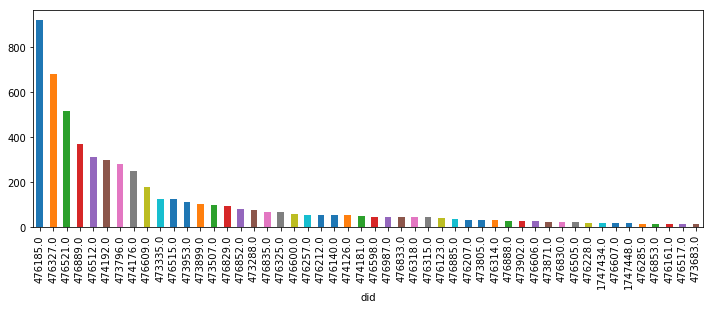

In [78]:
# Devices qui envoient le plus de messages :
%matplotlib inline
a1 = df_mess_train.groupby(by="did").messid.nunique().sort_values(0,ascending=False).median()
print(f'Medianne des messages envoyées par device : {a1}')

df_mess_train.groupby(by='did').messid.nunique().sort_values(0,ascending=False).iloc[:50].plot(kind='bar',figsize=(12,4))
plt.show()

On constate que la médiane des messages envoyés par device est de seulement 10. Tandis que des devices envoient énormément de de messages, comme on peut le voir sur le graphique plus haut. Cela risque de poser des problèmes par la suite lors du Leave One Device Out (LODO)

In [79]:
# On peut se poser la question si une base ne reçoit qu'une seule fois le même message :
a2 = df_mess_train.groupby('bsid').messid.count() # nombre de messages reçus par base
b2 = df_mess_train.groupby('bsid').messid.nunique() # nombre de messages uniques reçus par base
c2 = (a2-b2).sum()==0
print(f'Une base ne reçoit qu\'une seule fois le même message : {c2}')

Une base ne reçoit qu'une seule fois le même message : True


In [80]:
# Description du pos_train (Output train) :
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [81]:
pos_train.nunique()

lat    6004
lng    6004
dtype: int64

On constate qu'il y a moins de coordonnées réelles (=6004) qu'il n'y a de messages (=6068) => Des messages ont donc la même géolocalisation. Nous verrons cela plus loin dans les Outlayers.

### Comparaison des set test et train

In [82]:
diff_row = df_mess_train.shape[0]-df_mess_test.shape[0]
compare = pd.DataFrame(data=[[0,0,0,0,0,0,0,0]]*diff_row, columns=df_mess_train.columns)
compare = pd.concat([df_mess_test,compare])
comparison_matrix = (df_mess_train.reset_index(drop=True)==compare.reset_index(drop=True))
incommon_matrix = df_mess_train[comparison_matrix].dropna(how='all')

In [83]:
incommon_matrix.nunique()

messid      0
bsid       71
did         0
nseq        5
rssi       56
time_ux     0
bs_lat     61
bs_lng     61
dtype: int64

> **Le train et le test n'ont aucun message ni device en commun**

## Etudes des Outlayers et cleaning de données

### Etude des Oultlayers

In [182]:
# Concaténation de df_mess_train et pos_train utile par la suite : 
df_train = pd.concat(axis=1, objs=[df_mess_train,pos_train])
df_train.head(5)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


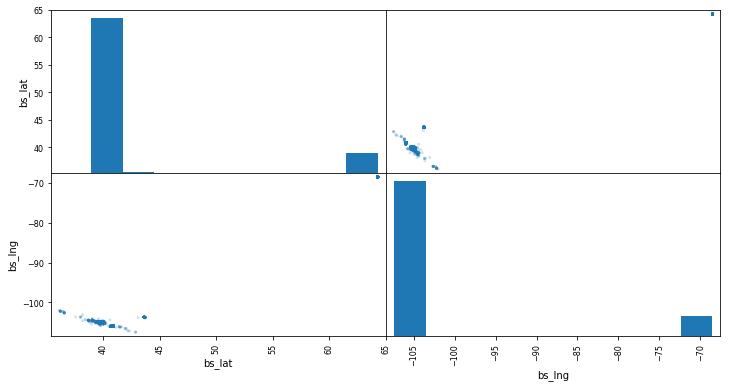

In [85]:
%matplotlib inline
pd.plotting.scatter_matrix(df_train.loc[:,['bs_lat','bs_lng']],diagonal='hist', alpha=0.2, figsize=(12,6))
plt.show()

On observe très vite qu'il y a un groupe de stations Outlayers en haut à droite

In [86]:
# Affichage des coordonnées ayant >1 bsid (autrement dit des bsid différents ayant les mêmes coordonnées) : 
a3 = df_train.groupby(['bs_lat','bs_lng']).nunique()[(df_train.groupby(['bs_lat','bs_lng']).nunique())['bsid']>1]
a3.loc[:,['bsid','messid']]

,,bsid,messid
bs_lat,bs_lng,,
39.680252,-104.925515,2,59
39.706436,-105.099323,2,333
39.730087,-104.919391,2,111
39.759461,-105.074287,2,504
64.300000,-68.500000,27,1849


Affichons ces coordonnées par rapport aux autres : 

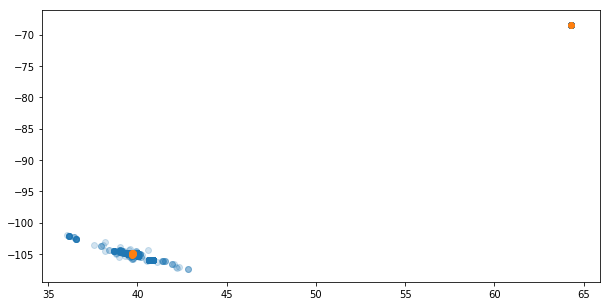

In [120]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.scatter(df_train.bs_lat,df_train.bs_lng, alpha=0.2)
plt.scatter(a3.index.get_level_values(0),a3.index.get_level_values(1))
plt.show()

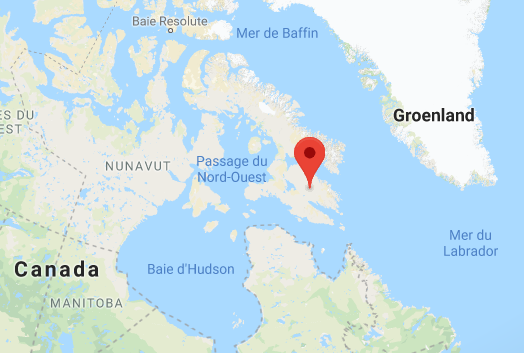

On se rend compte les coordonnées (64.300000,-68.500000) sont clairement un outlayer (les autres bases se situent dans le Colorado). Il est sans doute plus judicieux de les supprimer.

**Si on supprime ces bases que se passe-t-il ?**

In [88]:
# Nombre de messages qui arrivent sur les coordonnées (64.300000,-68.500000) : 
print('train:')
print('nombre de messages sur (64.300000,-68.500000)')
print(df_train[df_train.bs_lng==-68.5].messid.value_counts().sum())
print(f'Perte en volume du set : {df_train[df_train.bs_lng==-68.5].messid.value_counts().sum()/df_train.messid.count()*100:.2f}%')
print('\ntest:')
print('nombre de messages sur (64.300000,-68.500000)')
print(df_mess_test[df_mess_test.bs_lat==64.3].messid.value_counts().sum())
print(f'Perte en volume du set : {df_mess_test[df_mess_test.bs_lat==64.3].messid.value_counts().sum()/df_mess_test.messid.count()*100:.2f}%')

train:
nombre de messages sur (64.300000,-68.500000)
4389
Perte en volume du set : 11.18%

test:
nombre de messages sur (64.300000,-68.500000)
3069
Perte en volume du set : 10.48%


**On constate que l'on retrouve ces mêmes outlayers dans le jeu de test et cela représente 10% des messages ! Donc afin de ne pas biaiser l'apprentissage du modèle, nous allons tout de même les conserver par la suite tout en sachant qu'il s'agit d'outlayers.**

In [89]:
df_train_clean = df_train.drop(index=df_train[df_train.bs_lng==-68.5].index)
df_test_clean = df_mess_test.drop(index=df_mess_test[df_mess_test.bs_lng==-68.5].index)
df_train_clean.shape

(34861, 10)

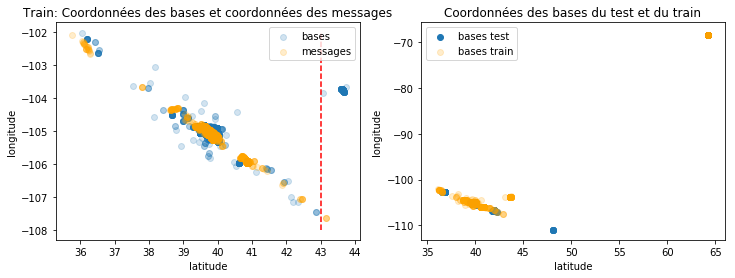

In [90]:
%matplotlib inline
# Superpostion des coordonnées des bases et des coordonnées réels : 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(df_train_clean.bs_lat,df_train_clean.bs_lng, alpha=0.2)
plt.scatter(pos_train.lat,pos_train.lng,c='orange',alpha=0.2)
plt.vlines(x=43,ymin=-108, ymax=-102,linestyles='--', colors='red')
plt.title('Train: Coordonnées des bases et coordonnées des messages')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend(('bases','messages'))

# Superposition des coordonnées des bases du test et du train : 
plt.subplot(1,2,2)
plt.scatter(df_mess_test.bs_lat,df_mess_test.bs_lng)
plt.scatter(df_train.bs_lat,df_train.bs_lng, alpha=0.2, c='orange')
plt.title('Coordonnées des bases du test et du train')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend(('bases test','bases train'))
plt.show()


Le graphiques de gauche nous donnent envi de sortir du train les coordonnées à droite du trait vertical (lat > 43°) qui semblent être des outlayers. Depuis comme on peut le constater sur le graphique de droite, ces bases n'existent pas dans le jeu de test. Par conséquent les supprimer n'aura aucun impact !

Par ailleurs, quand on observe le RSSI moyen et médian de ces messages, on se rend compte qu'il n'est pas bon : 

In [91]:
print(f'RSSI moyen : {df_train_clean[df_train_clean.bs_lat>43].rssi.mean()}')
print(f'RSSI median : {df_train_clean[df_train_clean.bs_lat>43].rssi.median()}')

RSSI moyen : -133.42696629214606
RSSI median : -135.0


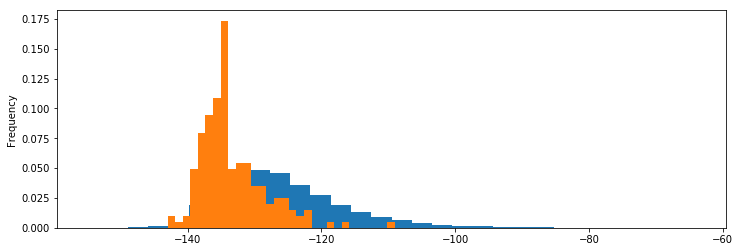

In [96]:
# Comparaison des RSSI Outlayers avec les autres RSSI :
%matplotlib inline
plt.figure(figsize=(12,4))
df_train.rssi.plot.hist(bins=30, density = True)
df_train_clean[df_train_clean.bs_lat>43].rssi.plot.hist(bins=30, density=True)
plt.show()

In [121]:
# Obeservation des bases situées entre la latitude 43 et 45
df_train_clean[df_train_clean.bs_lat>43].nunique()

messid     48
bsid       10
did         1
nseq        5
rssi       56
time_ux    48
bs_lat     10
bs_lng     10
lat         1
lng         1
dtype: int64

On se rend compte que ces bases dont la latitude est 43< lat <45 sont au nombre de 10 et ne captent qu'un seul device

In [119]:
a4 = df_train_clean[df_train_clean.bs_lat>43].did.value_counts()
print('device ID:')
print(a4.index.get_values()[0])
print()
b4 = df_train_clean[df_train_clean.bs_lat>43].bsid.value_counts()
print('Base ID:')
print(b4.index.get_values())
print()
print(df_train_clean[df_train_clean.did==a4.index.get_values()[0]].nunique())

device ID:
473288.0

Base ID:
[2800 2803 3848 3630 2808 3933 3501 4013 1443 7508]

messid     73
bsid       32
did         1
nseq        5
rssi       85
time_ux    73
bs_lat     32
bs_lng     32
lat        11
lng        11
dtype: int64


Par ailleurs ce device est capté par d'autres bases, il n'y a donc pas de mal à supprimer ces données du data set train.

### Cleaning de données

**En résumer nous allons seulement supprimer les messages dont les bases ont une latitude comprise en 43 et 45:**

In [183]:
to_drop = df_train[(df_train.bs_lat > 43) & (df_train.bs_lat <46)].index
df_train = df_train.drop(index=to_drop)

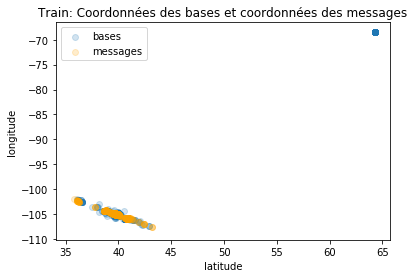

In [126]:
%matplotlib inline
plt.scatter(df_train.bs_lat,df_train.bs_lng, alpha=0.2)
plt.scatter(pos_train.lat,pos_train.lng,c='orange',alpha=0.2)
plt.title('Train: Coordonnées des bases et coordonnées des messages')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend(('bases','messages'))
plt.show()

====================================================================================================================

## Etude du RSSI et nombre de bases 

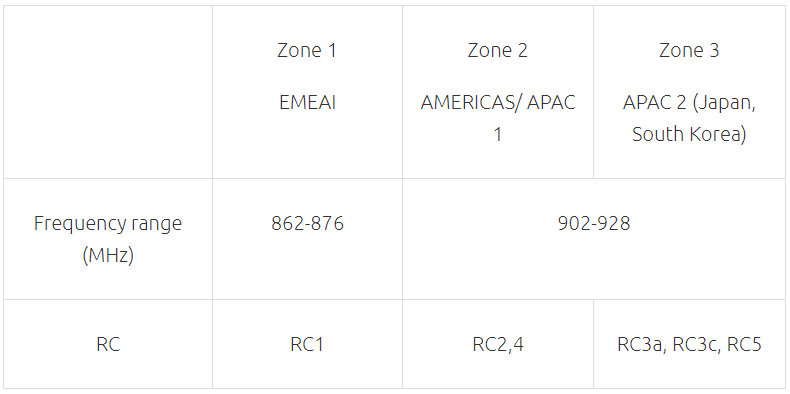

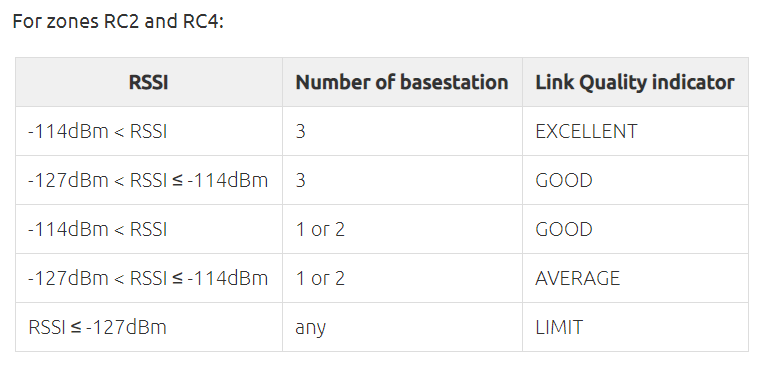

**On se rend compte que le RSSI est directement lié à la qualité du signal. De même que le nombre de bases qui reçoivent un même message**

RSSI median : -127.333333333


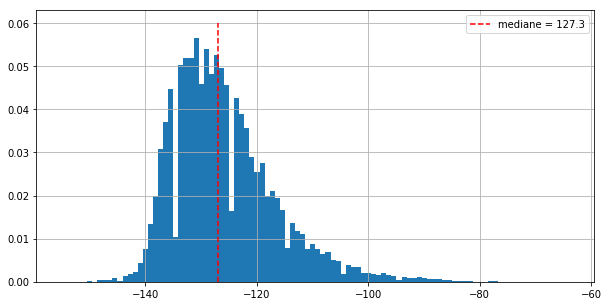

In [192]:
# Etude du signal RSSI pour le dataset de Train : 
%matplotlib inline

print(f'RSSI median : {df_train.rssi.median()}')
plt.figure(figsize=(10,5))
df_train.rssi.hist(bins=100, density=True, cumulative=False)
plt.vlines(x=-127, ymax=.06, ymin=0, linestyles='--',colors='r',label='mediane = 127.3')
plt.legend()
plt.show()


Mediane nombres de bases : 3.0


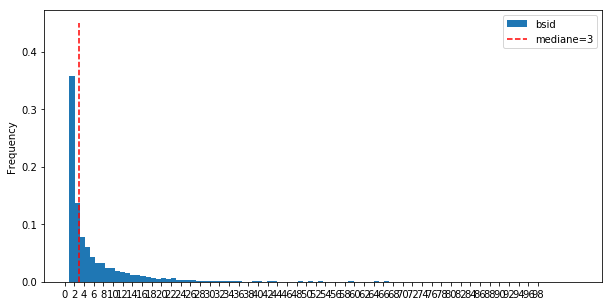

In [191]:
# Nombre de bases qui reçoivent le même message : 
%matplotlib inline

print(f"Mediane nombres de bases : {df_mess_train.groupby('messid').bsid.nunique().median()}")
plt.figure(figsize=(10,5))
df_mess_train.groupby('messid').bsid.nunique().plot.hist(bins=100, cumulative= False, density=True)
plt.vlines(x=3,ymax=0.45,ymin=0,linestyles='--', colors='r', label='mediane=3')
plt.xticks(ticks=np.arange(0,100,2))
plt.legend()
plt.show()

On constate que la qualité des messages reçus n'est globalement pas très bonne. D'après les tableaux décrits ci-dessus,<br>
on distingue 4 catégories de qaulité : Excellent, Bon, Moyen et Mauvais.
<br>
**Il semble judicieux de séparer notre jeux de données de la même manière afin de faciliter l'apprentissage des algorithmes et biaiser le moins possible l'apprentissage.**

## Séparation du jeu de données en 4 : Excellent, Bon, Moyen, Mauvais

Ici on sépare les jeux de données Train et Test suivant les critères décrits dans les tableaux vus précédemment pour la zone RC2 et RC4 : 


In [204]:
# cf. fonction split_set au début du notebook partie 1.1
df_train_bad, df_train_avg, df_train_good, df_train_excel = split_set(df_train)
X_test_bad, X_test_avg, X_test_good, X_test_excel = split_set(df_mess_test)
X_train_bad, y_train_bad = split_Xy(df_train_bad)
X_train_avg, y_train_avg = split_Xy(df_train_avg)
X_train_good, y_train_good = split_Xy(df_train_good)
X_train_excl, y_train_excel = split_Xy(df_train_excel)

print(f'Mauvais : {df_train_bad.shape}, Moyen : {df_train_avg.shape},\
Bon: {df_train_good.shape}, Excellent :{ df_train_excel.shape}')

Mauvais : (20853, 10), Moyen : (3788, 10),Bon: (12997, 10), Excellent :(1434, 10)


===============================================================================================================

## Quelques visualisation supplémentaires sur les devices

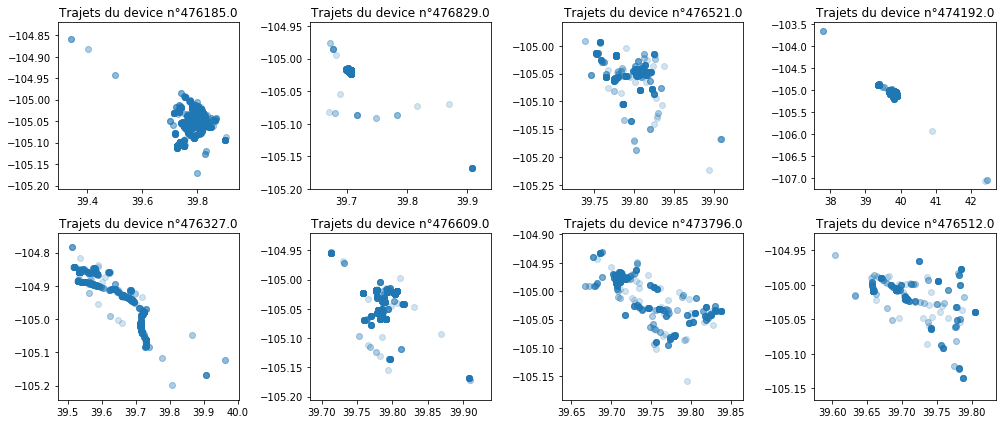

In [174]:
# plot la géolocalisation des n premiers devices
%matplotlib inline
n=8 # nombre de devices de 0 à 112
fig = plt.figure(figsize=(14,6))
for i in np.arange(n):
    plt.subplot(2,4,i+1)
    n_dev = df_train_clean.did.value_counts().index[i]
    dev_i = df_train_clean[df_train_clean.did==n_dev]
    plt.scatter(dev_i.lat,dev_i.lng,alpha=0.2)
    plt.title(f'Trajets du device n°{n_dev}')
plt.tight_layout()

<IPython.core.display.Javascript object>


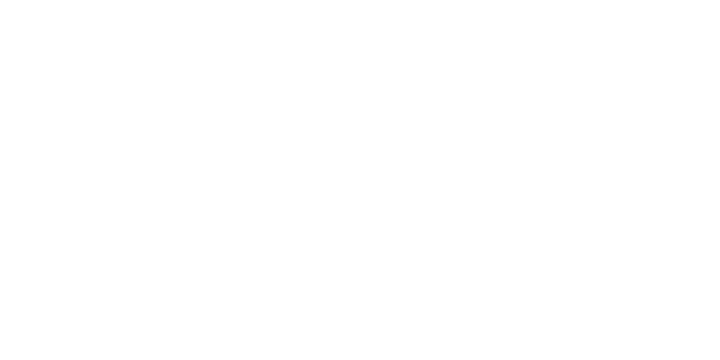

<IPython.core.display.Javascript object>


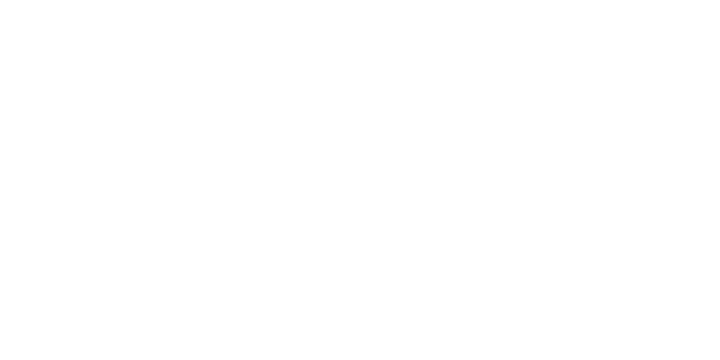

In [56]:
# Plot le déplacement d'un device en fonction du temps (graphique dynamique)
%matplotlib notebook
n=100 # nombre de time series
n_device= 476212.0 # choix du device

dev = df_train[df_train.did== n_device]
dev = dev.sort_values('time_ux')
fig = plt.figure(figsize=(8,4))
plt.title(f'Trajets du device n°{n_device}')
for i in np.arange(n):
    plt.scatter(dev.lat.iloc[i],dev.lng.iloc[i])
    fig.canvas.draw()

===============================================================================================================

## Transformation des features

De nombreux essais ont été faits pour le feature engineering et création de matrice pour l'entrainement de modèles. L'historique de ces tests se trouve dans la partie **Annexes** en fin de notebook.

La fonction de transformation est implémentée dans la partie 1.1 en haut du notebook
<br><br>
Transformation des features de la matrice:

1. Séparation en latitude et longitude des coordonnées des stations et OneHotencoding 
2. Pondération par l'inverse de la distance calculée à partir des RSSI
3. Pondération moyennées
4. Groupby Messid

def feat2(train,test) : 
<br>
   
    # Garde l'index de séparation entre le test et le train
    split = train.groupby('messid').max().shape[0]
    
    # Conversion du RSSI en distance et concaténation du test et du train
    train['rssi_conversion'] = [rssi_conversion(train.rssi.values[i]) for i in range(train.shape[0])]
    test['rssi_conversion'] = [rssi_conversion(test.rssi.values[i]) for i in range(test.shape[0])]
    concat = pd.concat([train,test], sort=False, copy=True)

    # Transformation des Latitudes des bases HotEncoded et pondérées par l'inverse de la distance RSSI
    oh_lat = pd.get_dummies(concat.bs_lat)
    weights = oh_lat.multiply((concat.rssi_conversion.values+concat.nseq.values)**-1, axis='index')
    oh_lat_weighted = weights#.multiply(oh_lat.columns.values)
    weights['messid'] = concat.messid
    oh_lat_weighted['messid'] = concat.messid
    numerateur_lat = oh_lat_weighted.groupby('messid',sort=False).sum()
    denom_lat = weights.groupby('messid',sort=False).sum().sum(axis=1)
    matrix_weighted_lat = numerateur_lat.multiply(denom_lat**-1, axis='index')

    # Transformation des Latitudes des bases hotencodées et pondérées par l'inverse de la distance RSSI
    oh_lng = pd.get_dummies(concat.bs_lng)
    weights = oh_lng.multiply((concat.rssi_conversion.values+concat.nseq.values)**-1, axis='index')
    oh_lng_weighted = weights#.multiply(oh_lng.columns.values)
    weights['messid'] = concat.messid
    oh_lng_weighted['messid'] = concat.messid
    numerateur_lng = oh_lng_weighted.groupby('messid',sort=False).sum()
    denom_lng = weights.groupby('messid',sort=False).sum().sum(axis=1)
    matrix_weighted_lng = numerateur_lng.multiply(denom_lng**-1, axis='index')

    # Concaténation des latitudes et longitudes HotEnconded
    output = pd.concat(axis=1, objs=[matrix_weighted_lat, matrix_weighted_lng], sort=False, copy=True)
    output_train = output.iloc[:split,:]
    output_test = output.iloc[split:,:]
    
    return output_train, output_test


## Leave One Device Out (LODO)

La fonction LODO est implémentée dans la partie 1.1 du notebook. Elle prend en entrée (X_train, y_train, X_test, model) et renvoie les résultats de la cross-validation par device. Chaque score est le percentile à 80% de la distance qui sépare le y_true de la prédiction. 
<br><i>(La fonction LODO fait appelle à la fonction feat2 décrite précédemment, c'est pourquoi elle prend aussi en entrée X_test même si elle ne l'utilise pas directement.)</i>

def lodo(X_train, y_train, X_test, model):
    
    df_concat = pd.concat(axis=1, objs=[X_train,y_train], sort=False, copy=True)
    X_train_new, X_test_new = feat2(X_train, X_test)
    y_train_new = pd.concat(axis=1,objs=[X_train.messid,y_train],sort=False, copy=True)
    y_train_new = y_train_new.groupby('messid', sort=False).mean()

    list_did = df_concat.did.unique()
    df_score = pd.DataFrame()
    
    # Fit le model sur tous les devices sauf 1 :
    for i in range (len(list_did)):
        
        # split en train et test: 
        train_msg_list = df_concat[df_concat['did'] != list_did[i]]['messid'].unique()
        test_msg_list = df_concat[df_concat['did'] == list_did[i]]['messid'].unique()
        train_set = X_train_new.loc[train_msg_list]
        train_y = y_train_new.loc[train_msg_list]
        test_set = X_train_new.loc[test_msg_list]
        test_y = y_train_new.loc[test_msg_list]
        
        # Model
        md = model.fit(train_set.values, train_y.values)
        
        # Prediction
        prediction = md.predict(test_set.values)
        score_lodo = score(md,test_set.values,test_y.values)*-1
        
        # Output
        a= pd.DataFrame(np.repeat(a=list_did[i],axis=0,repeats=test_set.shape[0]))
        b= pd.DataFrame(test_set.index.values)
        c= pd.DataFrame(np.repeat(a=score_lodo, axis=0, repeats=test_set.shape[0]))
        d= pd.DataFrame(prediction)
        e= test_y.reset_index(drop=True)
        f= pd.concat(axis=1, objs=[a,b,c,d,e], sort= False)
        df_score = df_score.append(f)   
    df_score = pd.DataFrame(data=df_score.values,
                            columns=['did','messid','dist_error','lat_pred','lng_pred','lat_true','lng_true'],
                            copy=True)
        
    return df_score

## Choix du model

In [4]:
# Par prudence, relancer cette cellule pour réinitialiser les variables et avoir les bons data set :
df_train = pd.concat(axis=1, objs=[df_mess_train,pos_train])
to_drop = df_train[(df_train.bs_lat > 43) & (df_train.bs_lat <46)].index
df_train = df_train.drop(index=to_drop)
df_train_bad, df_train_avg, df_train_good, df_train_excel = split_set(df_train)
X_test_bad, X_test_avg, X_test_good, X_test_excel = split_set(df_mess_test)
X_train_bad, y_train_bad = split_Xy(df_train_bad)
X_train_avg, y_train_avg = split_Xy(df_train_avg)
X_train_good, y_train_good = split_Xy(df_train_good)
X_train_excl, y_train_excel = split_Xy(df_train_excel)

Afin de choisir le modèle le plus performent nous allons tester différents algorithmes avec un LODO que l'en entraine sur l'ensemble du train set séparé en 4 (bon, mauvais, moyen excellent):

**Ce procédé prend énormément de temps !**

> 113 devices x 4 models x 4 jeux de données = 1808 prédictions

Pour cette raison ici nous n'avons pas testé sur de grandes profondeurs d'arbres ou de grands nombres d'estimateurs. Cela sert seulement à voir quel model de régression réagit le mieux aux données. Cepandant, nous optimisons les hyper-paramètres du model retenu par la suite.

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

knn = KNeighborsRegressor(n_neighbors=5, n_jobs=8)
knn.fit(Xtrain.values, ytrain.values) 


ext = ExtraTreesRegressor(max_depth=1000, n_estimators=1000,n_jobs=8,random_state=42)
ext.fit()

In [12]:
# modèle à tester : 
model_1 = ExtraTreesRegressor(n_estimators=10, n_jobs=8, random_state=42)
model_2 = KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2)
model_3 = MultiOutputRegressor(XGBRegressor(n_estimators=10, n_jobs=8, learning_rate=0.8, random_state=42))
model_4 = RandomForestRegressor(n_estimators=10, n_jobs=8, random_state=42)

list_score = []
# Boucle sur les 4 modèles à tester :
for i in np.arange(4):
    
    # Boucles sur les 4 jeux de données mauvais, moyen, bon et excellent : 
    for X_train, y_train, X_test in [('X_train_excel', 'y_train_excel', 'X_test_excel'),
                                     ('X_train_good', 'y_train_good', 'X_test_good'),
                                     ('X_train_avg', 'y_train_avg', 'X_test_avg'),
                                     ('X_train_bad', 'y_train_bad', 'X_test_bad')]:
        
        df_score = lodo(X_train=X_train, y_train=y_train, X_test=X_test, model=eval(f'model_{i+1}'))
        list_score.append(df_score)

**Le model retenu est l'ExtraTrees qui donne de meilleurs résultats en moyenne.**

Ici pour des raisons de simplicité nous n'affichons les résultats que du jeu de données "mauvais" :

In [299]:
m = 1 # numéro du modèle selectionné
j = 4 # numéro du jeu de donné
did_error_describe = list_score[m][j].groupby('did', sort=False).max().iloc[:,1:2].describe(percentiles=[.8])
did_error_describe

,dist_error
count,104.000000
mean,6564.354252
std,16975.476900
min,18.630391
50%,4085.411884
80%,6344.570983
max,168796.100314


<Figure size 1080x576 with 0 Axes>

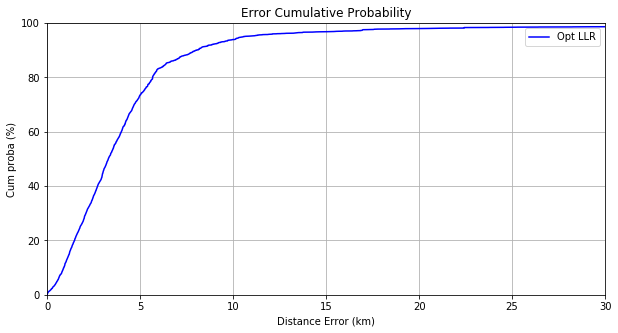

In [305]:
# Plot de la courbe d'erreur :

%matplotlib inline
plt.figure(figsize=(15,8))
y_pred = X_train_bad.set_index('messid').join(list_score[m].set_index('messid').iloc[:,2:4]).iloc[:,-2:]
plot_resultat(ypred=y_pred.values, ytest=y_train_bad.values)

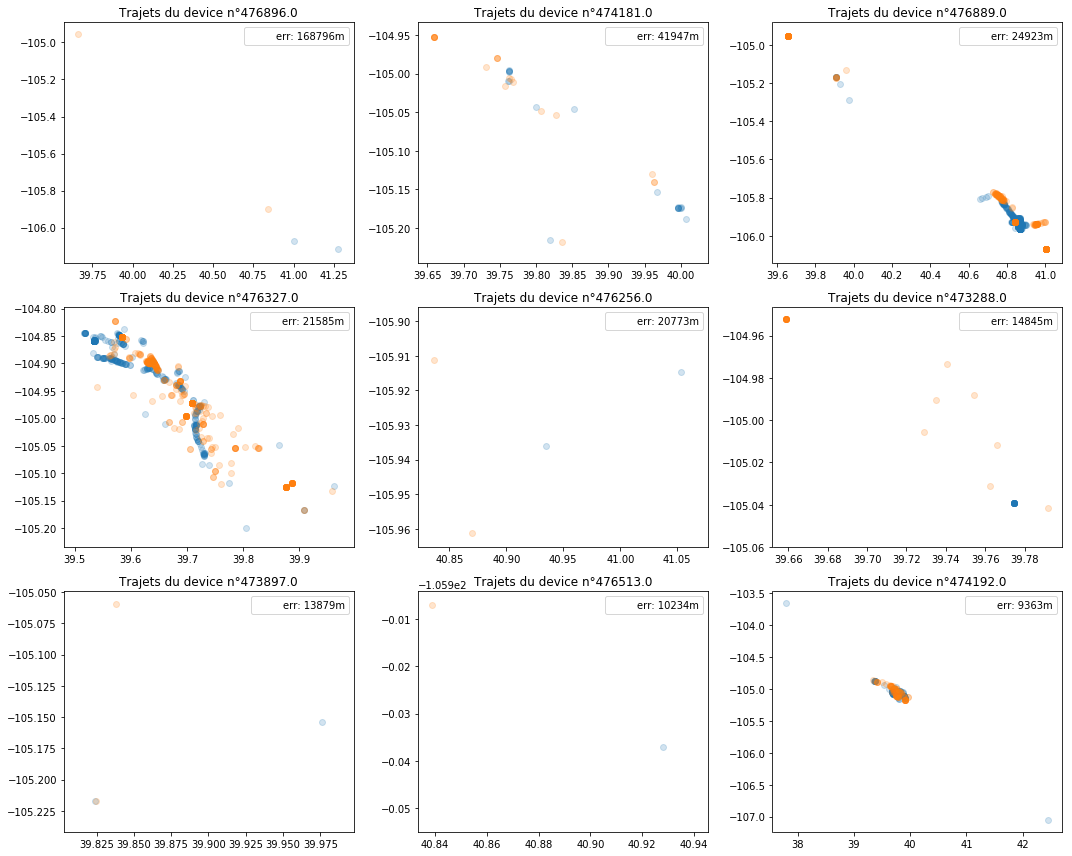

In [302]:
# Plot les coordonnées prédites et vraies des messages des 9 devices qui ont la plus grande erreur : 

%matplotlib inline
fig = plt.figure(figsize=(15,12))
for n in range(9):
    plt.subplot(3,3,n+1)
    n_dev = did_error.index[n]
    dev_i = mess_pred[mess_pred.did==n_dev]
#     plt.scatter(df_train.bs_lat,df_train.bs_lng, alpha=0.1)
    plt.scatter(dev_i.lat_true,dev_i.lng_true, alpha=0.2)
    plt.scatter(dev_i.lat_pred, dev_i.lng_pred, alpha=0.2)
    plt.legend([f'err: {did_error.iloc[n]:.0f}m'], markerscale=0)
    plt.title(f'Trajets du device n°{n_dev}')
plt.tight_layout()

## Optimisation du meilleur model

Pour l'optimisation du model nous nous sommes séparé les tâches et avons testé différents hyper-paramètres de notres côtés. Un GridSearch + LODO sur le même notebook prenait trop de temps. 

Les hyper-paramètres retenus sont les suivants :

## Résultat

In [5]:
df_train = pd.concat(axis=1, objs=[df_mess_train,pos_train])
to_drop = df_train[(df_train.bs_lat > 43) & (df_train.bs_lat <46)].index
df_train = df_train.drop(index=to_drop)
df_train = pd.concat(axis=1, objs=[df_mess_train,pos_train])

def split_Xy (df) :
    X = df.iloc[:,:-2]
    y = df.iloc[:,-2:]
    return X, y

def number_of_base_station(df):
    mess_bsid_inf3 = df.groupby(['messid']).bsid.nunique()[df.groupby(['messid']).bsid.nunique()<3].index
    df_bsid_sup3 = df.set_index('messid').drop(mess_bsid_inf3)

    mess_bsid_sup3 = df.groupby(['messid']).bsid.nunique()[df.groupby(['messid']).bsid.nunique()>=3].index
    df_bsid_inf3 = df.set_index('messid').drop(mess_bsid_sup3)
    
    return df_bsid_sup3.reset_index(), df_bsid_inf3.reset_index()

def split_set(df):
    # Signal mauvais : 
    df_train_bad = df[df.rssi<=-127]

    # Signal moyen et bon1 : 
    df_train_rssi_sup127 = df[df.rssi>-127]
    df_test_rssi_sup127_inf114 = df_train_rssi_sup127[df_train_rssi_sup127.rssi<=-114]
    df_train_good1 , df_train_avg = number_of_base_station(df_test_rssi_sup127_inf114)

    # Signal bon2 et excellent :
    df_train_sup114 = df[df.rssi>-114]
    df_train_excel , df_train_good2 = number_of_base_station(df_train_sup114)

    # signal bon:
    df_train_good = pd.concat(objs=[df_train_good1, df_train_good2], copy=True, sort=False)
    
    return df_train_bad, df_train_avg, df_train_good, df_train_excel

df_train_bad, df_train_avg, df_train_good, df_train_excel = split_set(df_train)
X_test_bad, X_test_avg, X_test_good, X_test_excel = split_set(df_mess_test)

print(df_train_bad.shape, df_train_avg.shape, df_train_good.shape, df_train_excel.shape)
print(X_test_bad.shape, X_test_avg.shape, X_test_good.shape, X_test_excel.shape)

X_train_bad, y_train_bad = split_Xy(df_train_bad)
X_train_avg, y_train_avg = split_Xy(df_train_avg)
X_train_good, y_train_good = split_Xy(df_train_good)
X_train_excel, y_train_excel = split_Xy(df_train_excel)

y_train_bad = pd.concat(axis=1,objs=[X_train_bad.messid,y_train_bad],sort=False, copy=True)
y_train_bad = y_train_bad.groupby('messid', sort=False).mean()

y_train_avg = pd.concat(axis=1,objs=[X_train_avg.messid,y_train_avg],sort=False, copy=True)
y_train_avg = y_train_avg.groupby('messid', sort=False).mean()

y_train_good = pd.concat(axis=1,objs=[X_train_good.messid,y_train_good],sort=False, copy=True)
y_train_good = y_train_good.groupby('messid', sort=False).mean()

y_train_excel = pd.concat(axis=1,objs=[X_train_excel.messid,y_train_excel],sort=False, copy=True)
y_train_excel = y_train_excel.groupby('messid', sort=False).mean()


(21015, 10) (3803, 10) (12998, 10) (1434, 10)
(15262, 8) (3685, 8) (9720, 8) (619, 8)


In [6]:
#Modèle choisi
Xtratrees = ExtraTreesRegressor(n_estimators = 1000,random_state = 2, n_jobs = -1, oob_score=True, bootstrap=True)

On entraîne par la suite les 4 modèles, sur le test set splitté. Les prédictions sont recueillies et concaténées.

In [7]:
# Model bad
X_train_bad_feat, X_test_bad_feat = feat2(X_train_bad, X_test_bad) 
Xtratrees.fit(X_train_bad_feat, y_train_bad)
Xtratrees.score(X_train_bad_feat, y_train_bad)
# Predict
predictions_1 = Xtratrees.predict(X_test_bad_feat)
predictions_1 = pd.DataFrame(predictions_1)
ypred = pd.concat(axis=1, objs=[X_test_bad.groupby('messid',as_index=False).max().messid,predictions_1], sort=False,copy=False)
pred = X_test_bad.set_index('messid').join(ypred.set_index('messid')[0])
pred = pred.join(ypred.set_index('messid')[1])

y_pred_bad_short = ypred.set_index(ypred['messid'])
y_pred_bad_short = y_pred_bad_short.drop('messid', axis = 1)
y_pred_bad_short.columns = ['lat', 'lng']

y_pred_bad_full = pred.iloc[:,-2:]

In [8]:
X_train_avg_feat, X_test_avg_feat = feat2(X_train_avg, X_test_avg) 
Xtratrees.fit(X_train_avg_feat, y_train_avg)
print(Xtratrees.score(X_train_avg_feat, y_train_avg))
# Predict
predictions_2 = Xtratrees.predict(X_test_avg_feat)
predictions_2 = pd.DataFrame(predictions_2)
ypred = pd.concat(axis=1, objs=[X_test_avg.groupby('messid',as_index=False).max().messid,predictions_2], sort=False,copy=False)
pred = X_test_avg.set_index('messid').join(ypred.set_index('messid')[0])
pred = pred.join(ypred.set_index('messid')[1])

y_pred_avg_short = ypred.set_index(ypred['messid'])
y_pred_avg_short = y_pred_avg_short.drop('messid', axis = 1)
y_pred_avg_short.columns = ['lat', 'lng']

y_pred_avg_full = pred.iloc[:,-2:]

0.9809940172599447


In [9]:
X_train_good_feat, X_test_good_feat = feat2(X_train_good, X_test_good) 
Xtratrees.fit(X_train_good_feat, y_train_good)
print(Xtratrees.score(X_train_good_feat, y_train_good))
# Predict
predictions_3 = Xtratrees.predict(X_test_good_feat)
predictions_3 = pd.DataFrame(predictions_3)
ypred = pd.concat(axis=1, objs=[X_test_good.groupby('messid',as_index=False).max().messid,predictions_3], sort=False,copy=False)
pred = X_test_good.set_index('messid').join(ypred.set_index('messid')[0])
pred = pred.join(ypred.set_index('messid')[1])

y_pred_good_short = ypred.set_index(ypred['messid'])
y_pred_good_short = y_pred_good_short.drop('messid', axis = 1)
y_pred_good_short.columns = ['lat', 'lng']

y_pred_good_full = pred.iloc[:,-2:]

0.9964643382604879


In [10]:
X_train_excel_feat, X_test_excel_feat = feat2(X_train_excel, X_test_excel) 
Xtratrees.fit(X_train_excel_feat, y_train_excel)
print(Xtratrees.score(X_train_excel_feat, y_train_excel))
# Predict
predictions_4 = Xtratrees.predict(X_test_excel_feat)
predictions_4 = pd.DataFrame(predictions_4)
ypred = pd.concat(axis=1, objs=[X_test_excel.groupby('messid',as_index=False).max().messid,predictions_4], sort=False,copy=False)
pred = X_test_excel.set_index('messid').join(ypred.set_index('messid')[0])
pred = pred.join(ypred.set_index('messid')[1])

y_pred_excel_short = ypred.set_index(ypred['messid'])
y_pred_excel_short = y_pred_excel_short.drop('messid', axis = 1)
y_pred_excel_short.columns = ['lat', 'lng']

y_pred_excel_full = pred.iloc[:,-2:]

0.9963128050480907


In [16]:
# Construction des prédictions
predictions_full = pd.concat([y_pred_bad_full, y_pred_avg_full, y_pred_good_full, y_pred_excel_full], axis = 0)
predictions_full.columns = ['lat', 'lng']
df_mess_test['id'] = df_mess_test.index
u = df_mess_test.join(predictions_full, on = 'messid').groupby('id').max()

predictions_in_order_full = u[['lat', 'lng', 'messid']]
predictions_in_order_full.to_csv('pred_pos_test_list_full.csv', index=False)

predictions_short = pd.concat([y_pred_bad_short, y_pred_avg_short, y_pred_good_short, y_pred_excel_short], axis = 0)
predictions_short.columns = ['lat', 'lng']
# au cas où un message appartienne à plusieurs catégories, on choisit de prendre la prédiction donnée par le modèle de la meilleure qualité de rssi
predictions_short['messid'] = predictions_short.index
predictions_short = predictions_short.drop_duplicates(subset = 'messid', keep='last')
predictions_short = predictions_short.reset_index(drop = True)
predictions_short.to_csv('pred_pos_test_list.csv', index=False)

In [17]:
predictions_short.head()

,lat,lng,messid
0,39.784134,-105.039595,573c2d133e952e19128e5fc9
1,39.783963,-105.136514,573c5200864fce1a9a38329a
2,39.788386,-105.056118,573c6ab1f0fe6e735aa9801f
3,39.788386,-105.056118,573c9063864fce1a9a60d02e
4,39.699556,-105.010517,573c983a3e952e1912d6c5ce


In [18]:
predictions_short.shape

(5294, 3)

In [19]:
predictions_in_order_full.shape

(29286, 3)

In [20]:
predictions_in_order_full.head()

,lat,lng,messid
id,,,
0,39.737239,-105.067334,573be2503e952e191262c351
1,39.783942,-105.072265,573c05f83e952e1912758013
2,39.783942,-105.072265,573c05f83e952e1912758013
3,39.783942,-105.072265,573c05f83e952e1912758013
4,39.783942,-105.072265,573c05f83e952e1912758013


## Annexes : Anciennes transformations et models testés (INUTILE)

### Préparation des données

In [177]:
# Séparation du train set en train + test
dftrain_complet = pd.concat(axis=1, objs=[df_mess_train,pos_train],copy=True)
listOf_did = dftrain_complet.groupby('did', as_index=False).max().did
random.Random(1000).shuffle(listOf_did)

df_train = dftrain_complet[dftrain_complet.did.isin(listOf_did[:65])]
df_test = dftrain_complet[dftrain_complet.did.isin(listOf_did[65:])]

# Séparation du train  en X et y 
X = df_train.iloc[:,:-2]
y = df_train.iloc[:,-2:]

# Groupement des y par Messid, utile par la suite
ygroup = pd.concat(axis=1,objs=[X.messid,y],sort=False, copy=True)
ygroup = ygroup.groupby('messid',sort=False).mean()
ygroup = ygroup.reset_index(drop=True)

# Séparation du test en X_test et y_test
X_test = df_test.iloc[:,:-2]
y_test = df_test.iloc[:,-2:]

# Groupement des y_test par Messid, utile par la suite
ygroup_test = pd.concat(axis=1,objs=[X_test.messid,y_test],sort=False, copy=True)
ygroup_test = ygroup_test.groupby('messid',sort=False).mean()
ygroup_test = ygroup_test.reset_index(drop=True)
print(f'X : {X.shape}, y : {y.shape}, ygroup : {ygroup.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}, ygroup_test : {ygroup_test.shape}')

X : (20269, 8), y : (20269, 2), ygroup : (3143, 2)
X_test : (18981, 8), y_test : (18981, 2), ygroup_test : (2925, 2)


### Baseline - RandomForest 

In [35]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X_0, pos_train, test_size=0.2, random_state=42)
# print(Xtrain.shape, ytrain.shape)

X_0 = X.drop(columns=['messid','did','time_ux'])
X_0_test = X_test.drop(columns=['messid','did','time_ux'])

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(X_0.values, y.values)
baseline = score(rf,X_0_test.values,y_test.values)*-1
print(f'Score prédiction : {baseline}')

Score prédiction : 7985.891301333702


In [36]:
# df_score = lodo(X_0,pos_train,df_mess_train, RandomForestRegressor(n_jobs=8))
# y_pred = df_score.sort_values('messid')[['lat_pred', 'lng_pred']]
# baseline = my_score(ypred=y_pred.values,ytest=pos_train.values)
# baseline

### Model-0 : RandomForest + cleaning sans Transformation

In [123]:
# Cleaning du dataframe, suppression des Outlayers :
df = df_train
df_train_clean = df.drop(index=df[df.bs_lng==-68.5].index)
df_train_clean2 = df_train_clean.drop(index=df_train_clean[df_train_clean.bs_lat>43].index)
df = df_train_clean2

# Séparation du train "clean" en X et y 
X = df.iloc[:,:-2]
y = df.iloc[:,-2:]

# Groupement des y par Messid, utile par la suite
ygroup = pd.concat(axis=1,objs=[X.messid,y],sort=False,copy=True)
ygroup = ygroup.groupby('messid',sort=False).mean()
ygroup = ygroup.reset_index(drop=True)

print(f'X : {X.shape}, y : {y.shape}, ygroup : {ygroup.shape}')

X : (17652, 8), y : (17652, 2), ygroup : (3053, 2)


In [64]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X_pre, y, test_size=0.2, random_state=42)
# print(Xtrain.shape, ytrain.shape)
X_pre = X.drop(columns=['messid','did','time_ux'])
X_pre_test = X_test.drop(columns=['messid','did','time_ux'])

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(X_pre.values, y.values)
Model_0 = score(rf,X_pre_test.values,y_test.values)*-1
print(f'Score prédiction : {Model_0}')

Score prédiction : 10647.32505606602


In [39]:
# X_pre = X.drop(columns=['messid','did','time_ux'])
# df_score = lodo(X_pre,y,df, RandomForestRegressor(n_jobs=8))
# y_pred = df_score.sort_values('messid')[['lat_pred', 'lng_pred']]
# model_0 = my_score(ypred=y_pred.values,ytest=y.values)
# model_0

Ici l'objectif est de créer plusieurs transformations différentes et comparer leurs résultas en les testant sur un Random Forest

Transformation 1 : une colonne par bs_lat et bs_lng. Chaque colonne est pondérée par le rssi et le nseq associé au messid

In [124]:
# Concaténation du train et du test pour avoir les mêmes transformations sur les 2 sets
concat = pd.concat([X, X_test], sort=False, copy=True)

# Application de la transformation 1
df_oh = feat(concat)
df_oh.head()

,messid,36.0533936861,36.187011678800005,36.4343876437,36.5287044515,36.5559381931,37.5382053103,37.9637853398,37.9673102044,38.0404365429,...,-103.671045026,-103.63315728399999,-103.540996981,-103.046811979,-102.631195011,-102.548383841,-102.297175809,-102.208966477,-102.011461391,-68.5
0,573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,573bf3533e952e19126b256a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [125]:
df_oh.describe()

,36.0533936861,36.187011678800005,36.4343876437,36.5287044515,36.5559381931,37.5382053103,37.9637853398,37.9673102044,38.0404365429,38.1535335179,...,-103.671045026,-103.63315728399999,-103.540996981,-103.046811979,-102.631195011,-102.548383841,-102.297175809,-102.208966477,-102.011461391,-68.5
count,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,...,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000,36633.000000
mean,0.000002,0.000030,0.000007,0.000022,0.000005,0.000003,0.000006,0.000003,0.000002,0.000003,...,-0.000004,-0.000007,-0.000005,-0.000006,-0.000061,-0.000013,-0.000019,-0.000085,-0.000005,-0.016897
std,0.000340,0.001784,0.000769,0.001514,0.000647,0.000499,0.000921,0.000505,0.000366,0.000479,...,0.000785,0.001378,0.000996,0.001089,0.004254,0.001814,0.002160,0.005039,0.000963,0.159952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.150332,-0.263841,-0.190657,-0.208425,-0.397645,-0.293680,-0.284420,-0.396009,-0.184372,-24.002104
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
max,0.065162,0.140207,0.101300,0.141531,0.104690,0.095569,0.156483,0.096661,0.070047,0.091646,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [126]:
# Séparation de nouveau en train et test après transformation des features
X_oh = df_oh.iloc[:X.shape[0],:]
test_oh = df_oh.iloc[X.shape[0]:,:]
print(X_oh.shape)
print(test_oh.shape)

(17652, 443)
(18981, 443)


Transformation 2  = Transformation 1 + Ajout des features nseq par ligne de messid

In [127]:
X_oh_full = pd.DataFrame(data=pd.concat(axis=1,objs=[X_oh.iloc[:,1:],pd.get_dummies(X.nseq)],sort=False, copy=True).values,
                         columns=pd.concat(axis=1,objs=[X_oh.iloc[:,1:],pd.get_dummies(X.nseq)],sort=False, copy=True).columns,index=X_oh.messid)
X_oh_full.shape

(17652, 447)

Transformation 3  = Transformation 1 + Groupage par messid

In [128]:
X_oh_group = X_oh.groupby('messid',sort=False).mean()
print(X_oh_group.shape)

(3053, 442)


Transformation 4  = Transformation 1 + Ajout des features nseq par ligne de messid + groupage par messid

In [129]:
X_oh_full_group = X_oh_full.groupby('messid',sort=False).sum()
X_oh_full_group.shape

(3053, 447)

Transformation 5 = OneHotEncoder API

In [133]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_pre = X.drop(columns=['messid','did','time_ux'])
X_pre = X_pre[['bs_lat','bs_lng']]
X_ohe = ohe.fit_transform(X_pre) 
print(f'Shape du Xtrain transformé par ohe : {X_ohe.shape}\n')
print(X_ohe[1])

Shape du Xtrain transformé par ohe : (17652, 362)

  (0, 45)	1.0
  (0, 311)	1.0


In [138]:
X_pre.nunique()

bs_lat    181
bs_lng    181
dtype: int64

In [139]:
X_ohe.todense().shape

(17652, 362)

Transformation 6 = Transformation 1 + ajout time_ux + groupage par messid

In [47]:
X_oh_gr_time = pd.DataFrame(data=pd.concat(axis=1,objs=[X_oh.iloc[:,1:],X.time_ux],sort=False, copy=True).values,
                            columns=pd.concat(axis=1,objs=[X_oh.iloc[:,1:],X.time_ux],sort=False,copy=True).columns,index=X_oh.messid)
X_oh_gr_time = X_oh_gr_time.groupby('messid',sort=False).mean()
X_oh_gr_time.head()

,36.0533936861,36.187011678800005,36.4343876437,36.5287044515,36.5559381931,37.5382053103,37.9637853398,37.9673102044,38.0404365429,38.1535335179,...,-103.63315728399999,-103.540996981,-103.046811979,-102.631195011,-102.548383841,-102.297175809,-102.208966477,-102.011461391,-68.5,time_ux
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.463546e+12
573bf3533e952e19126b256a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.463547e+12
573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.463553e+12
573c1272f0fe6e735a6cb8bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.463555e+12
573c8ea8864fce1a9a5fbf7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.463586e+12


Transformation 7 = cleaning + encod (cf.fonction)

In [48]:
Xnew, X_test = feat2(X,X_test)
Xnew.head()

,36.0533936861,36.187011678800005,36.4343876437,36.5287044515,36.5559381931,37.5382053103,37.9637853398,37.9673102044,38.0404365429,38.1535335179,...,-103.671045026,-103.63315728399999,-103.540996981,-103.046811979,-102.631195011,-102.548383841,-102.297175809,-102.208966477,-102.011461391,-68.5
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model-1 : RandomForest + Transformation 2

In [49]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_oh_full, y, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(Xtrain.values, ytrain.values)

Model_1 = score(rf,Xtest.values,ytest.values)*-1
print(Model_1)

(14121, 447) (14121, 2)
6125.338624210429


### Model-2 : RandomForest + Transformation 3

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_oh_group, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(Xtrain.values, ytrain.values)

Model_2 = score(rf,Xtest.values,ytest.values)*-1
print(Model_2)

(2442, 442) (2442, 2)
3381.1226670563788


### Model-3 : RandomForest + Transformation 4

In [51]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_oh_full_group, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(Xtrain.values, ytrain.values)

Model_3 = score(rf,Xtest.values,ytest.values)*-1
print(Model_3)

(2442, 447) (2442, 2)
3269.3885293943185


### Model-4 : RandomForest + Transformation 5

In [52]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_ohe, y, test_size=0.2, random_state=42)
print(Xtrain.shape, ytrain.shape)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(Xtrain, ytrain)

# Model_4 = score(rf,Xtest.values,ytest.values)*-1
Model_4 = 'error'
print(Model_4)

(14121, 810) (14121, 2)
error


### Model-5 : RandomForest + Transformation 7

In [53]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

rf = RandomForestRegressor(n_estimators=128, n_jobs=8, random_state=42)
rf.fit(Xtrain.values, ytrain.values)

Model_5 = score(rf,Xtest.values,ytest.values)*-1
print(Model_5)

(2442, 442) (2442, 2)
3011.5178955201245


#### Features Selection

In [175]:
# %matplotlib inline
# feat_imp = pd.DataFrame(data=rf.feature_importances_.reshape(1,-1), columns=X_oh_group.columns).T
# feat_imp.sort_values(0, ascending=False).cumsum().iloc[:50,:].plot(kind='bar',figsize=(10,5))
# plt.hlines(y=0.95,xmin=0,xmax=50,linestyles='--')
# plt.title('Importance des features à 95%')
# plt.show()

# feat_95 = feat_imp.sort_values(0, ascending=False).cumsum().iloc[:50,:].index
# X_oh_group_reduced = X_oh_group[feat_95]

### Model-6 : GradientBoosting + Transfomation 7

In [55]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

mo_gb = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.8,n_estimators=1280,verbose=False,random_state=42))
mo_gb.fit(Xtrain.values,ytrain.values)

Model_6 = score(mo_gb,Xtest.values,ytest.values)*-1
print(Model_6)

(2442, 442) (2442, 2)
4234.765186378992


### Model-7 : KNN + Transfomation 7

In [56]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

knn = KNeighborsRegressor(n_neighbors=5, n_jobs=8)
knn.fit(Xtrain.values, ytrain.values) 

Model_7 = score(knn,Xtest.values,ytest.values)*-1
print(Model_7)

(2442, 442) (2442, 2)
3118.1430795488536


### Model-8 : SVM + Transfomation 7

In [57]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ygroup, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
print(Xtrain.shape, ytrain.shape)

svr = MultiOutputRegressor(svm.SVR(gamma='scale'))
svr.fit(Xtrain.values, ytrain.values)

Model_8 = score(svr,Xtest.values,ytest.values)*-1
print(Model_8)

(2442, 442) (2442, 2)
11766.86535615466


### Model-9 : MLP Reg (for Fun)

In [58]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
Xtrain = Xtrain.loc[:,['nseq','rssi','bs_lat','bs_lng']]
Xtest = Xtest.loc[:,['nseq','rssi','bs_lat','bs_lng']]
print(Xtrain.shape, ytrain.shape)

mlp = MLPRegressor(max_iter=200,hidden_layer_sizes=(1000,))
mlp.fit(Xtrain.values,ytrain.values)

Model_9 = score(mlp,Xtest.values,ytest.values)*-1
print(Model_9)

(14121, 4) (14121, 2)
10012.127478318556


### Model Summary

In [65]:
n_model = 10
list_model = [eval(f'Model_{i}') for i in np.arange(n_model)]
list_model.append(baseline)
index = [f'Model_{i}' for i in np.arange(n_model)]
index.append('baseline')
summary = pd.DataFrame(data=list_model,columns=['Distance à 80%'],index=index)
summary.drop('Model_4').sort_values('Distance à 80%')

,Distance à 80%
Model_5,3011.52
Model_7,3118.14
Model_3,3269.39
Model_2,3381.12
Model_6,4234.77
Model_1,6125.34
baseline,7985.89
Model_9,10012.1
Model_0,10647.3
Model_8,11766.9
